In [2]:
import os

import matplotlib.pyplot as plt
import ultraplot as uplt
import xarray as xr
from shapely import from_wkt

plt.matplotlib.rcParams["image.cmap"] = "RdBu_r"

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".20"
plt.rcParams["image.cmap"] = "RdBu"


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
box_egms = from_wkt(
    "POLYGON((-29.1292 66.2244,-9.6201 41.964,36.7733 49.8148,32.8477 71.2128,24.4017 71.4035,-29.1292 66.2244))"
)

In [4]:
import asyncio

import zarr


class RetryingFsspecStore(zarr.storage.FsspecStore):
    max_attempts = 5
    backoff = 0.1

    async def get(
        self,
        key: str,
        prototype: zarr.core.buffer.core.BufferPrototype,
        byte_range: zarr.abc.store.ByteRequest | None = None,
    ) -> zarr.core.buffer.Buffer | None:
        for attempt in range(self.max_attempts):
            try:
                return await super().get(key, prototype, byte_range)
            except Exception:
                if attempt >= self.max_attempts - 1:
                    raise
                await asyncio.sleep(self.backoff * (2**attempt))

        raise AssertionError("Unreachable")


In [5]:
store = RetryingFsspecStore.from_url(
    "https://data.dynamical.org/noaa/gefs/analysis/latest.zarr?email=scott.stanie@utexas.edu"
)
ds = xr.open_zarr(store, decode_timedelta=True, chunks=None)
ds

<xarray.Dataset> Size: 7TB
Dimensions:                                     (time: 74966, latitude: 721,
                                                 longitude: 1440)
Coordinates:
  * latitude                                    (latitude) float64 6kB 90.0 ....
  * longitude                                   (longitude) float64 12kB -180...
    spatial_ref                                 int64 8B ...
  * time                                        (time) datetime64[ns] 600kB 2...
Data variables: (12/21)
    categorical_freezing_rain_surface           (time, latitude, longitude) float32 311GB ...
    categorical_ice_pellets_surface             (time, latitude, longitude) float32 311GB ...
    categorical_rain_surface                    (time, latitude, longitude) float32 311GB ...
    categorical_snow_surface                    (time, latitude, longitude) float32 311GB ...
    downward_long_wave_radiation_flux_surface   (time, latitude, longitude) float32 311GB ...
    downward_short_wave_radiation_flux_surface  (time, latitude, longitude) float32 311GB ...
    ...                                          ...
    temperature_2m                              (time, latitude, longitude) float32 311GB ...
    total_cloud_cover_atmosphere                (time, latitude, longitude) float32 311GB ...
    wind_u_100m                                 (time, latitude, longitude) float32 311GB ...
    wind_u_10m                                  (time, latitude, longitude) float32 311GB ...
    wind_v_100m                                 (time, latitude, longitude) float32 311GB ...
    wind_v_10m                                  (time, latitude, longitude) float32 311GB ...
Attributes:
    dataset_id:          noaa-gefs-analysis
    dataset_version:     0.1.2
    name:                NOAA GEFS analysis
    description:         Weather analysis from the Global Ensemble Forecast S...
    attribution:         NOAA NWS NCEP GEFS data processed by dynamical.org f...
    spatial_domain:      Global
    spatial_resolution:  0.25 degrees (~20km)
    time_domain:         2000-01-01 00:00:00 UTC to Present
    time_resolution:     3.0 hours

In [11]:
for dv in ds.data_vars:
    print(f"{dv}: {ds[dv].size / 1e9:.1f} GB")

categorical_freezing_rain_surface: 77.8 GB

categorical_ice_pellets_surface: 77.8 GB

categorical_rain_surface: 77.8 GB

categorical_snow_surface: 77.8 GB

downward_long_wave_radiation_flux_surface: 77.8 GB

downward_short_wave_radiation_flux_surface: 77.8 GB

geopotential_height_cloud_ceiling: 77.8 GB

maximum_temperature_2m: 77.8 GB

minimum_temperature_2m: 77.8 GB

percent_frozen_precipitation_surface: 77.8 GB

precipitable_water_atmosphere: 77.8 GB

precipitation_surface: 77.8 GB

pressure_reduced_to_mean_sea_level: 77.8 GB

pressure_surface: 77.8 GB

relative_humidity_2m: 77.8 GB

temperature_2m: 77.8 GB

total_cloud_cover_atmosphere: 77.8 GB

wind_u_100m: 77.8 GB

wind_u_10m: 77.8 GB

wind_v_100m: 77.8 GB

wind_v_10m: 77.8 GB

In [8]:
lonmin, latmin, lonmax, latmax = box_egms.bounds

In [11]:
data_vars = [
    "categorical_snow_surface",
    "temperature_2m",
    # "minimum_temperature_2m",
    # "maximum_temperature_2m",
]
lat_slice = latitude=slice(latmax, latmin)
lon_slice = longitude=slice(lonmin, lonmax)
time_slice = slice("2020-01-01", None)
ds_sub = ds[data_vars].sel(time=time_slice, latitude=lat_slice, longitude=lon_slice)
ds_sub

<xarray.Dataset> Size: 4GB
Dimensions:                   (time: 16524, latitude: 118, longitude: 264)
Coordinates:
  * latitude                  (latitude) float64 944B 71.25 71.0 ... 42.25 42.0
  * longitude                 (longitude) float64 2kB -29.0 -28.75 ... 36.75
    spatial_ref               int64 8B ...
  * time                      (time) datetime64[ns] 132kB 2020-01-01 ... 2025...
Data variables:
    categorical_snow_surface  (time, latitude, longitude) float32 2GB ...
    temperature_2m            (time, latitude, longitude) float32 2GB ...
Attributes:
    dataset_id:          noaa-gefs-analysis
    dataset_version:     0.1.2
    name:                NOAA GEFS analysis
    description:         Weather analysis from the Global Ensemble Forecast S...
    attribution:         NOAA NWS NCEP GEFS data processed by dynamical.org f...
    spatial_domain:      Global
    spatial_resolution:  0.25 degrees (~20km)
    time_domain:         2000-01-01 00:00:00 UTC to Present
    time_resolution:     3.0 hours

In [12]:
ds_sub.temperature_2m.shape, ds_sub.temperature_2m.size * 4 / 1e9

((16524, 118, 264), 2.059022592)

In [13]:
from zarr.codecs import BloscCodec

ntime, rows, cols = ds_sub.temperature_2m.shape

new_chunks = {"time": 1440 // 3, "latitude": rows, "longitude": cols}
new_encoding = {
    "chunks": tuple(new_chunks.values()),
    "compressors": [BloscCodec(cname="zstd", clevel=6)],
}
encoding = dict.fromkeys(ds_sub.data_vars, new_encoding)

In [14]:
%%time
ds_sub.chunk({"time": 1440 // 3, "longitude": -1, "latitude": -1}).to_zarr(
    "egms_noaa_gefs.zarr", encoding=encoding, consolidated=False
)

CPU times: user 2min 5s, sys: 26.1 s, total: 2min 31s
Wall time: 9min 44s


In [15]:
!du -h -d1

 92K	./.ipynb_checkpoints
476M	./noaa_gefs.zarr
492M	.


In [16]:
ds_local = xr.open_zarr("egms_noaa_gefs.zarr", consolidated=False)
ds_local

<xarray.Dataset> Size: 4GB
Dimensions:                   (time: 16524, latitude: 118, longitude: 264)
Coordinates:
  * time                      (time) datetime64[ns] 132kB 2020-01-01 ... 2025...
  * longitude                 (longitude) float64 2kB -29.0 -28.75 ... 36.75
  * latitude                  (latitude) float64 944B 71.25 71.0 ... 42.25 42.0
    spatial_ref               int64 8B ...
Data variables:
    temperature_2m            (time, latitude, longitude) float32 2GB dask.array<chunksize=(480, 118, 264), meta=np.ndarray>
    categorical_snow_surface  (time, latitude, longitude) float32 2GB dask.array<chunksize=(480, 118, 264), meta=np.ndarray>
Attributes:
    dataset_id:          noaa-gefs-analysis
    dataset_version:     0.1.2
    name:                NOAA GEFS analysis
    description:         Weather analysis from the Global Ensemble Forecast S...
    attribution:         NOAA NWS NCEP GEFS data processed by dynamical.org f...
    spatial_domain:      Global
    spatial_resolution:  0.25 degrees (~20km)
    time_domain:         2000-01-01 00:00:00 UTC to Present
    time_resolution:     3.0 hours

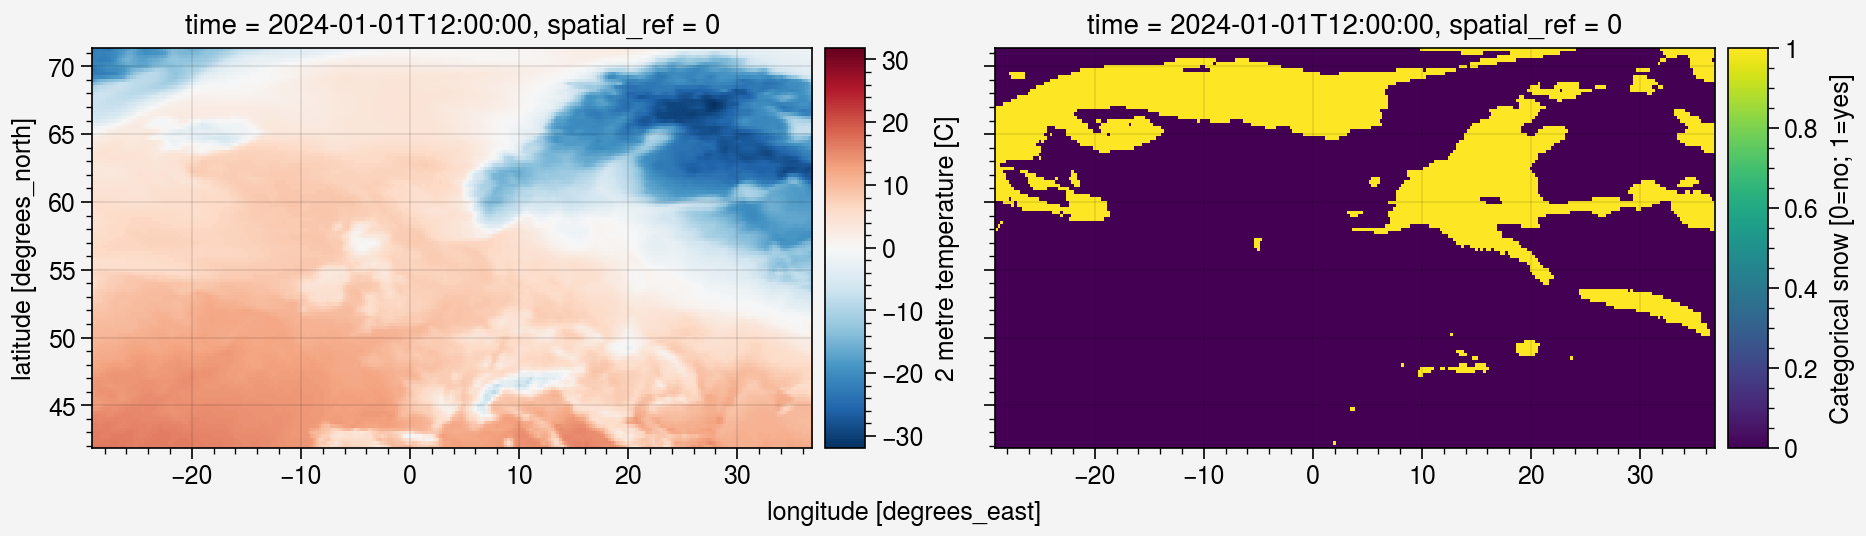

In [17]:
fig, axes = uplt.subplots(ncols=2, refwidth=3.6, refheight=2)

d = ds_local.sel(time="2024-01-01 12:00:00")

d.temperature_2m.plot.imshow(ax=axes[0])
d.categorical_snow_surface.plot.imshow(ax=axes[1])